In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import numpy as np

In [58]:
df = pd.read_pickle('../results/results.pkl')

In [69]:
def get_rows(
    args_dict,
):
    idx = {}
    for key, value in args_dict.items():
        if value is None:
            idx[key] = np.ones_like(df[key], dtype=bool)
        else:
            idx[key] = df[key] == value
        
    run_idx = np.ones_like(df['test_loss'], dtype=bool)
    for key, value in idx.items():
        run_idx = run_idx & value
    
    # print(f"Selected {run_idx.sum()} runs!")
    
    run_df = df[run_idx].reset_index(drop=True)   
    return run_df

def get_loss(
    args_dict,
    mtc_l = ['test_loss', 'train_loss'],
):
    run_df = get_rows(args_dict)

    rank_set = list(np.unique(run_df['rank']))
    if 0 in rank_set: rank_set.remove(0)
    seed_set = np.unique(run_df['seed'])
    metric, metric_median = {}, {}
    output = {}
    
    normal_df = run_df[run_df['tune_bias'] == 1].reset_index(drop=True)
    for method in ['sgd', 'ours']:
        group_df = normal_df[normal_df['method'] == method].reset_index(drop=True)   
        for mtc in mtc_l:
            metric[mtc], metric_median[mtc] = {}, {}

            for rank in rank_set:
                rank_df = group_df[group_df['rank'] == rank].reset_index(drop=True)
                metric[mtc][rank] = {}
                for seed in seed_set:
                    seed_df = rank_df[rank_df['seed'] == seed].reset_index(drop=True)   
                    
                    if method == 'sgd':     
                        try:
                            sgd_df = seed_df[seed_df['n_train'] == 400*args_dict['target_depth']].reset_index(drop=True)  
                            min_loss_index = sgd_df['val_loss'].idxmin()
                            row_with_min_loss = sgd_df.loc[min_loss_index]
                            metric[mtc][rank][seed] = row_with_min_loss[mtc]
                        except ValueError:
                            print(rank,seed)
                    elif method == 'ours':
                        try:
                            metric[mtc][rank][seed] = seed_df[mtc].iloc[0]
                        except IndexError:
                            print(rank,seed)
                    else:
                        raise ValueError('method must be sgd or ours')
                metric_median[mtc][rank] = pd.Series(metric[mtc][rank]).median()
        output[method] = pd.DataFrame({mtc: metric_median[mtc] for mtc in mtc_l})
        
    return output

In [70]:

activation = 'relu'
use_bias = 1
width = 16
exp = 'fnn'
init_mode = 'default'
pretrained = 0

fnn_results = {}
for target_depth in [1,2]:
    frozen_depth = 2 * target_depth
    fnn_results[target_depth] = get_loss({
        'activation': activation,
        'use_bias': use_bias,
        'target_depth': target_depth,
        'frozen_depth': frozen_depth,
        'init_mode': init_mode,
        'width': width,
        'exp': exp,
        'pretrained': pretrained,
        'rank_step': 0,
        'task': 'regression',
        'best_epoch': 0,
    })
    


/skunk-pod-storage-yzeng58-40wisc-2eedu-pvc/anaconda3/envs/ibm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/skunk-pod-storage-yzeng58-40wisc-2eedu-pvc/anaconda3/envs/ibm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/skunk-pod-storage-yzeng58-40wisc-2eedu-pvc/anaconda3/envs/ibm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/skunk-pod-storage-yzeng58-40wisc-2eedu-pvc/anaconda3/envs/ibm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/skunk-pod-storage-yzeng58-40wisc-2eedu-pvc/anaconda3/envs/ibm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarnin

1 2
16 0
1 2
16 0


/skunk-pod-storage-yzeng58-40wisc-2eedu-pvc/anaconda3/envs/ibm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/skunk-pod-storage-yzeng58-40wisc-2eedu-pvc/anaconda3/envs/ibm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/skunk-pod-storage-yzeng58-40wisc-2eedu-pvc/anaconda3/envs/ibm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/skunk-pod-storage-yzeng58-40wisc-2eedu-pvc/anaconda3/envs/ibm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/skunk-pod-storage-yzeng58-40wisc-2eedu-pvc/anaconda3/envs/ibm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarnin

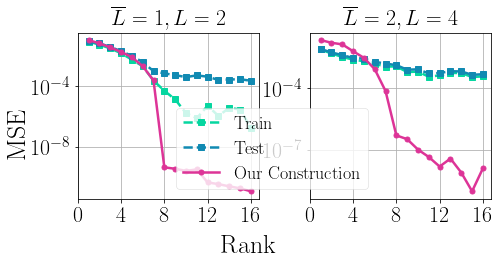

In [74]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

sgd_marker, sgd_color, sgd_lt, sgd_ms = 's', '#118AB2', '--', 6
our_marker, our_color, our_lt, our_ms = 'o', '#DD3497', '-', 5
sgd2_marker, sgd2_color, sgd2_lt, sgd2_ms = 's', '#06D6A0', '-.', 6
lw = 2.5

fig, ax = plt.subplots(nrows=1, ncols=2, sharey = False)
fig.subplots_adjust(left=0.16, bottom=.24, right=0.98, top=0.9, wspace=0.28, hspace = 0.3) #margin of the figure
fig.set_size_inches(7, 3.5) #exact size of the figure

for target_depth in [1,2]:
    fnn_results[target_depth]['sgd']['train_loss'].plot(ax = ax[target_depth-1], color = sgd2_color, label = 'Train', linestyle = sgd_lt, marker = sgd2_marker, linewidth = lw, markersize = sgd2_ms, logy = True)
    fnn_results[target_depth]['sgd']['test_loss'].plot(ax = ax[target_depth-1], color = sgd_color, label = 'Test', linestyle = sgd_lt, marker = sgd_marker, linewidth = lw, markersize = sgd_ms, logy = True)
    fnn_results[target_depth]['ours']['test_loss'].plot(ax = ax[target_depth-1], color = our_color, label = 'Our Construction', linestyle = our_lt, marker = our_marker, linewidth = lw, markersize = our_ms, logy = True)
    ax[target_depth-1].grid(True)
    ax[target_depth-1].set_xticks([0,4,8,12,16])
    
ax[0].set_title(r'$\overline{L}=1, L=2$', size = 22, y = 1.01)
ax[1].set_title(r'$\overline{L}=2, L=4$', size = 22, y = 1.01)

ax[1].legend(fontsize=18, bbox_to_anchor=(0.37,.6))
fig.supxlabel('Rank', fontsize = 26)
fig.supylabel('MSE', fontsize = 26)
    
plt.savefig('../figures/train_test_gen_ours.pdf')
# Show the plot
plt.show()

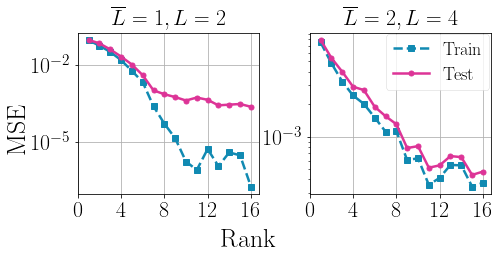

In [79]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

sgd_marker, sgd_color, sgd_lt, sgd_ms = 's', '#118AB2', '--', 6
our_marker, our_color, our_lt, our_ms = 'o', '#DD3497', '-', 5
sgd2_marker, sgd2_color, sgd2_lt, sgd2_ms = 's', '#06D6A0', '-.', 6
lw = 2.5

fig, ax = plt.subplots(nrows=1, ncols=2, sharey = False)
fig.subplots_adjust(left=0.16, bottom=.24, right=0.98, top=0.88, wspace=0.28, hspace = 0.3) #margin of the figure
fig.set_size_inches(7, 3.5) #exact size of the figure

for target_depth in [1,2]:
    fnn_results[target_depth]['sgd']['train_loss'].plot(ax = ax[target_depth-1], color = sgd_color, label = 'Train', linestyle = sgd_lt, marker = sgd_marker, linewidth = lw, markersize = sgd_ms, logy = True)
    # fnn_results[target_depth]['sgd']['test_loss'].plot(ax = ax[target_depth-1], color = sgd_color, label = 'Test', linestyle = sgd_lt, marker = sgd_marker, linewidth = lw, markersize = sgd_ms, logy = True)
    fnn_results[target_depth]['sgd']['test_loss'].plot(ax = ax[target_depth-1], color = our_color, label = 'Test', linestyle = our_lt, marker = our_marker, linewidth = lw, markersize = our_ms, logy = True)
    ax[target_depth-1].grid(True)
    ax[target_depth-1].set_xticks([0,4,8,12,16])
    
ax[0].set_title(r'$\overline{L}=1, L=2$', size = 22, y = 1.01)
ax[1].set_title(r'$\overline{L}=2, L=4$', size = 22, y = 1.01)

ax[1].legend(fontsize=18, bbox_to_anchor=(0.37,.59))
fig.supxlabel('Rank', fontsize = 26)
fig.supylabel('MSE', fontsize = 26)
    
plt.savefig('../figures/train_test_gen.pdf')
# Show the plot
plt.show()